# California House Price Prediction

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from pathlib import Path

# Machine Learning Processing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings("ignore")

In [4]:
# Get Main Path to work with the files
__ROOT_PATH__ = Path().resolve().parent
dataset_path = __ROOT_PATH__ / "data/housing_dataset.csv"

In [5]:
data = pd.read_csv(dataset_path, sep=",")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

## Data Exploration

In [6]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [6]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

For sure we can drop this NaN data, because it's less then 5% of my data. 5% less, is the recomended amount that we can drop "without" hesitation

But let's create a flow of why we are not using it.

In [8]:
# Checking the amount of Nan Data
nan_amount = data.isnull().sum().sum()
total_amount = len(data)

percent_amount = round(nan_amount / total_amount, ndigits=3) * 100
print(f"NaN data represents: {percent_amount}% of the dataset")

NaN data represents: 1.0% of the dataset


In [9]:
data_cleaned = data.copy()
data_cleaned.dropna(inplace=True)
data_cleaned.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

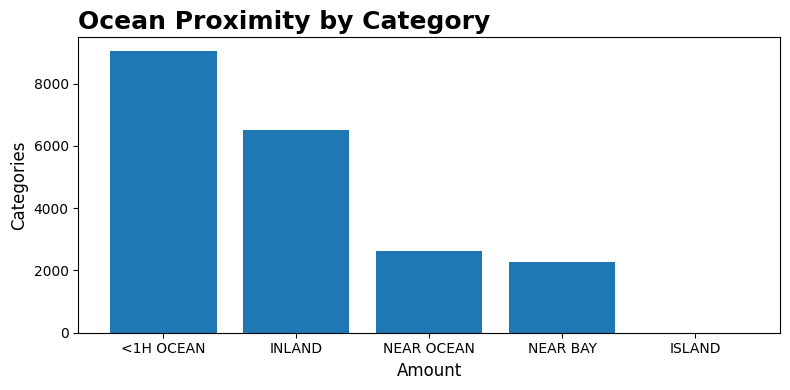

In [10]:
dict_ocean_proximity = data_cleaned["ocean_proximity"].value_counts().to_dict()
labels_ = dict_ocean_proximity.keys()
values_ = dict_ocean_proximity.values()

plt.figure(figsize=(8, 4))
plt.bar(x=labels_, height=values_)
plt.title("Ocean Proximity by Category",
          loc="left",
          size=18,
          fontweight="bold")
plt.xlabel("Amount", size=12)
plt.ylabel("Categories", size=12)
plt.tight_layout()
plt.show()

In [11]:
list_ocean_proximity = list(data_cleaned["ocean_proximity"].unique())
range_ocean_proximity = range(0, len(list_ocean_proximity))


mapping = dict(zip(list_ocean_proximity, range_ocean_proximity))

data_cleaned["ocean_proximity_class"] = data_cleaned["ocean_proximity"].map(mapping)

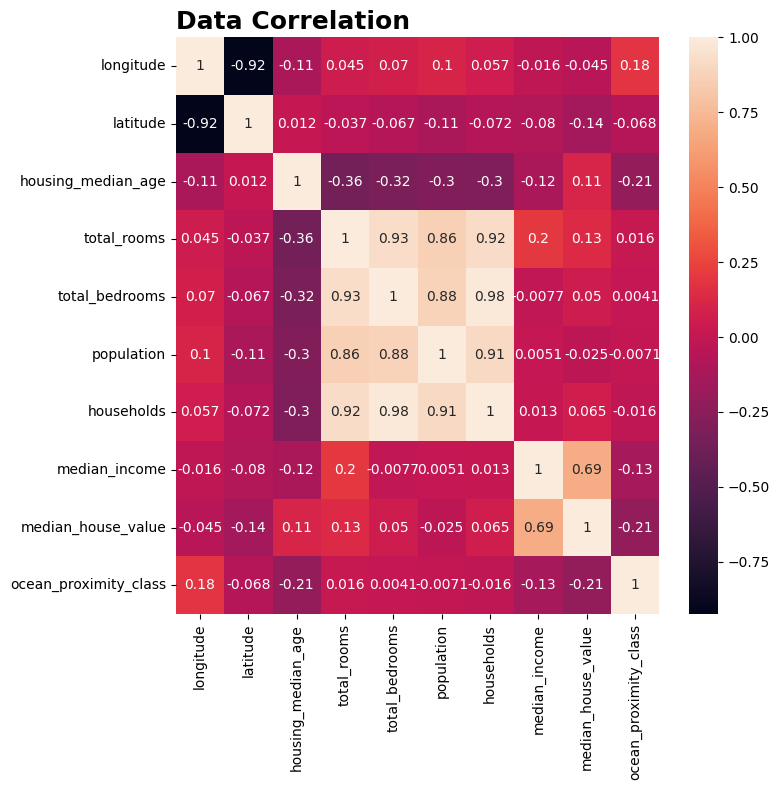

In [12]:
numeric_titles = [
    i for i in data_cleaned.columns if not data_cleaned[i].dtype==type(object)
    ]

data_corr = data_cleaned.loc[:, numeric_titles]
correlation_data_v1 = data_corr.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_data_v1, annot=True)
plt.title("Data Correlation", loc="left", size=18, fontweight="bold")
plt.tight_layout()
plt.show()

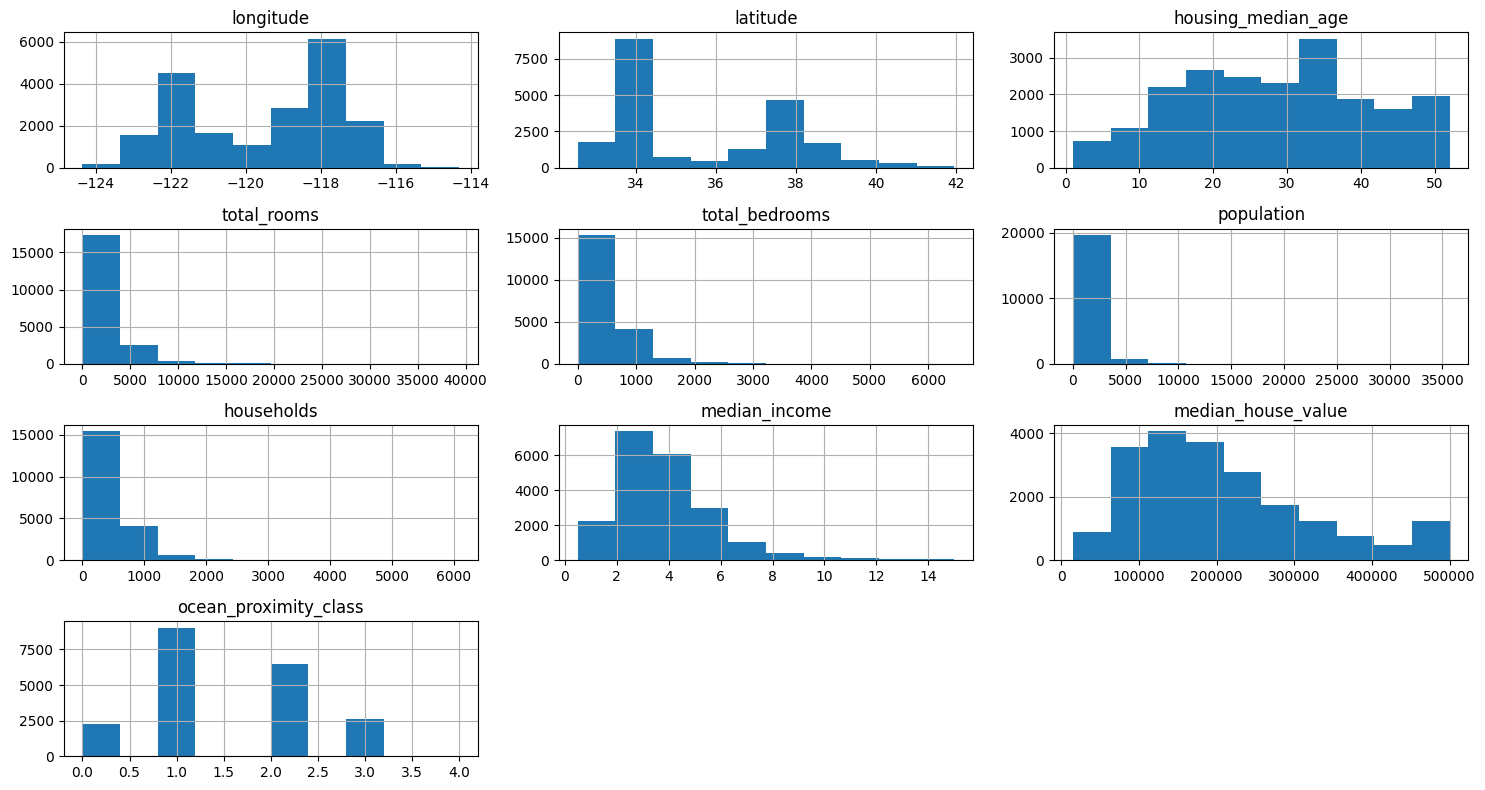

In [13]:
data_cleaned.hist(figsize=(15, 8))
plt.tight_layout()
plt.show()

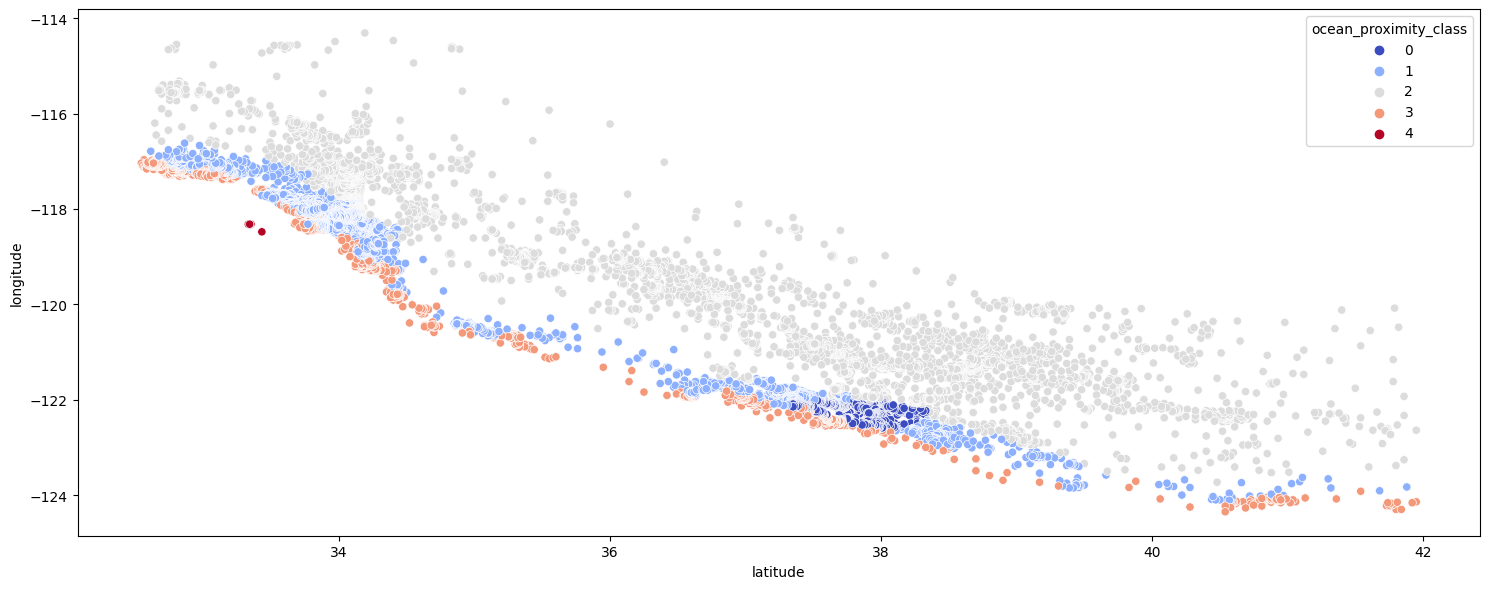

In [14]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=data_cleaned, x="latitude", y="longitude", hue="ocean_proximity_class", palette="coolwarm")
plt.tight_layout()
plt.show()

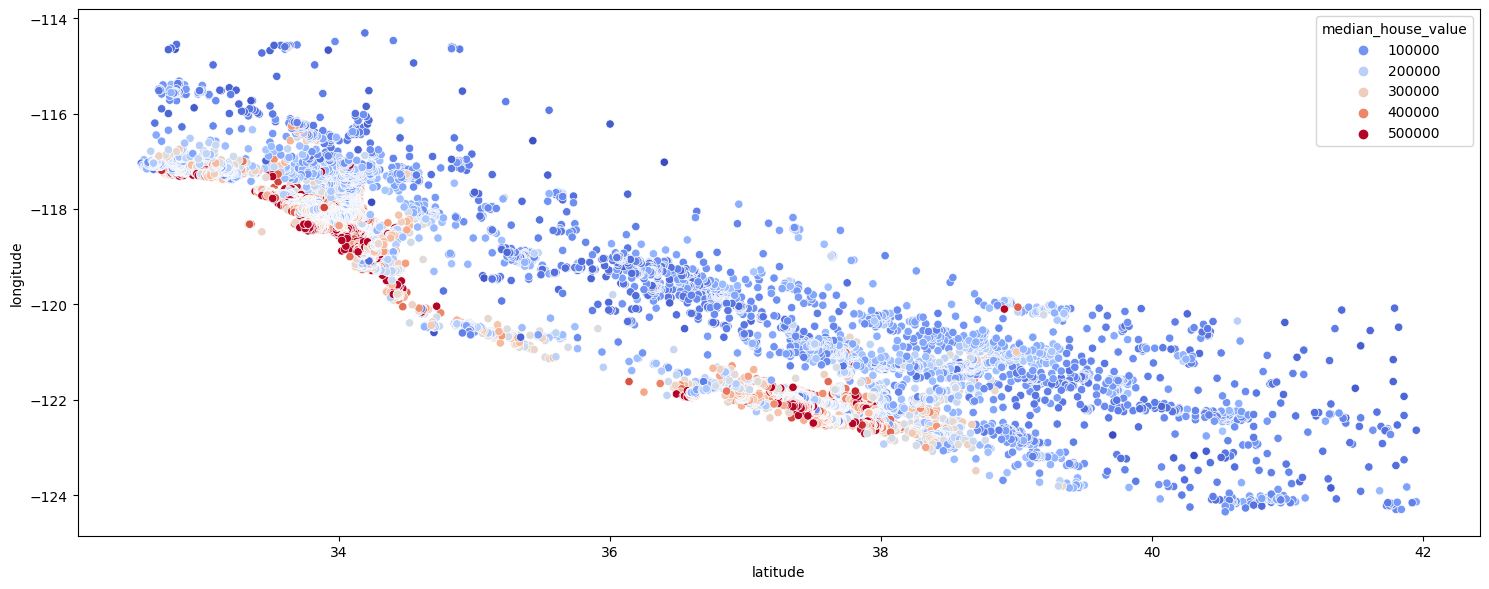

In [15]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=data_cleaned, x="latitude", y="longitude", hue="median_house_value", palette="coolwarm")
plt.tight_layout()
plt.show()

# Feature Engineering

In [16]:
room_index = pd.DataFrame()
room_index["room_index"] = data_cleaned["total_rooms"] / data_cleaned["total_bedrooms"]
room_index["median_house_value"] = data_cleaned["median_house_value"]
room_index.head()
print(room_index.corr())

                    room_index  median_house_value
room_index             1.00000             0.38392
median_house_value     0.38392             1.00000


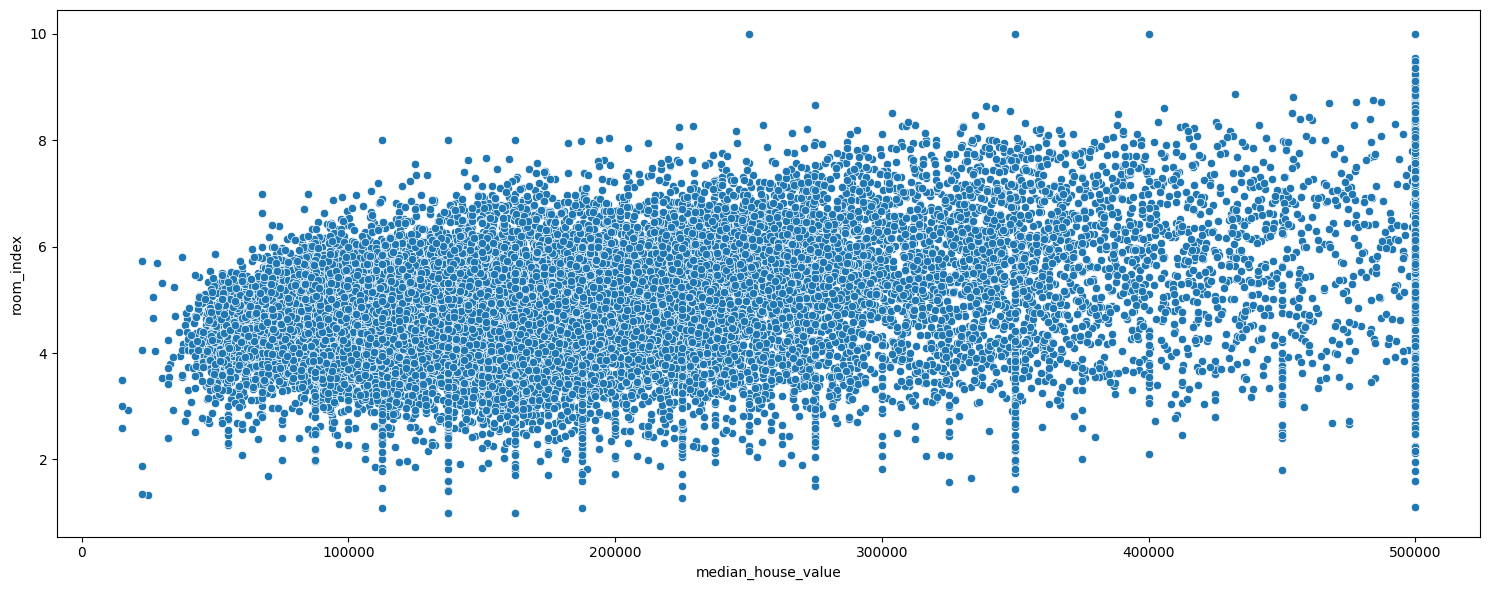

In [17]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=room_index, x="median_house_value", y="room_index", palette="coolwarm")
plt.tight_layout()
plt.show()

In [18]:
data_v1 = data_cleaned.join(pd.get_dummies(data_cleaned["ocean_proximity"], dtype=int), how="inner")
data_v1["room_index"] = data_cleaned["total_rooms"] / data_cleaned["total_bedrooms"]
data_v1.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_class,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,room_index
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0,0,0,0,1,0,6.821705
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0,0,0,0,1,0,6.418626
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0,0,0,0,1,0,7.721053
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0,0,0,0,1,0,5.421277
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0,0,0,0,1,0,5.810714


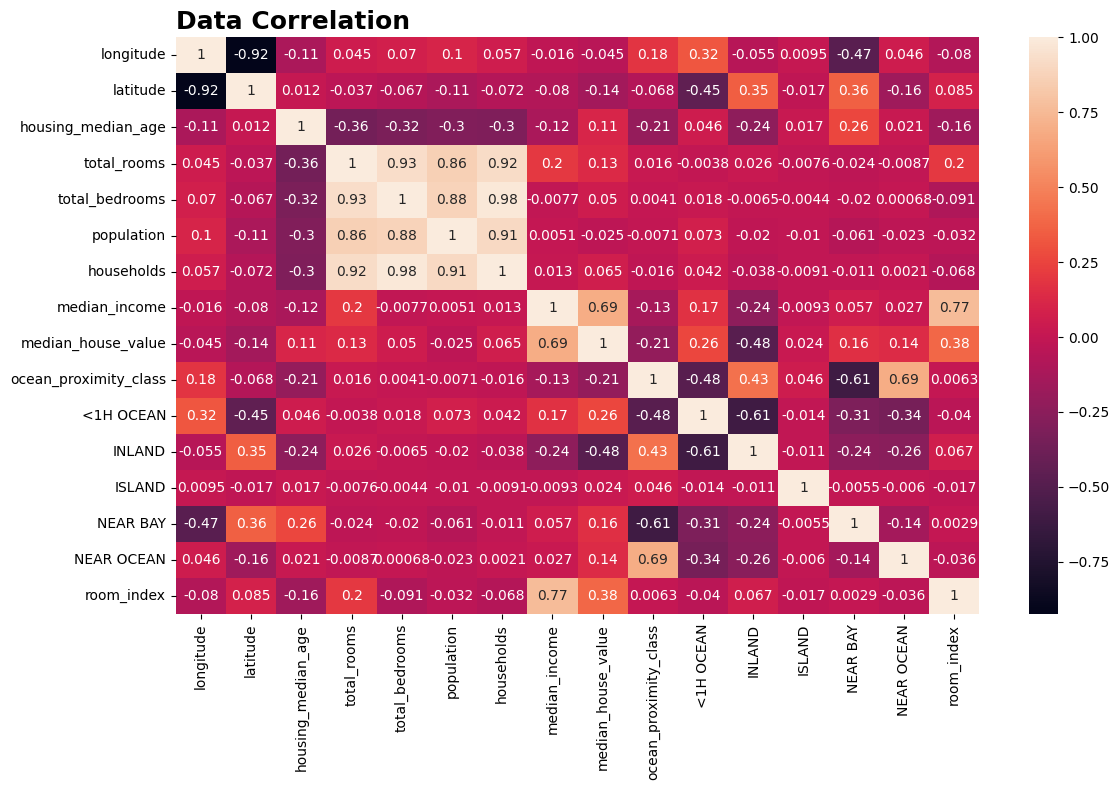

In [19]:
numeric_titles = [
    i for i in data_v1.columns if not data_v1[i].dtype==type(object)
    ]

data_corr_v2 = data_v1.loc[:, numeric_titles]
correlation_data_v2 = data_corr_v2.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_data_v2, annot=True)
plt.title("Data Correlation", loc="left", size=18, fontweight="bold")
plt.tight_layout()
plt.show()

In [20]:
y = data_v1["median_house_value"]
X = data_v1
X.drop([y.name, "ocean_proximity", "ocean_proximity_class"], axis=1, inplace=True)

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    shuffle=True
                                                    )

print(X_train_base.shape)
print(y_train_base.shape)
print()
print(X_test_base.shape)
print(y_test_base.shape)

(14303, 14)
(14303,)

(6130, 14)
(6130,)


## Creating Base Model

In [21]:
# Creating Model with all variables
base_model = LinearRegression(n_jobs=100)

# Training Model
base_model.fit(X_train_base, y_train_base)

LinearRegression(n_jobs=100)

In [22]:
base_test = base_model.predict(X_test_base)

r2_base_model = r2_score(y_test_base, base_test)
print(f"Model's r² Score: {r2_base_model * 100}")

Model's r² Score: 64.28638978624082


## Feature Selection

In [23]:
related_variables = [
    title for title in correlation_data_v2[
        "median_house_value"
        ].index 
        if not abs(
    correlation_data_v2[
        "median_house_value"
        ][title] * 100
            ) >= 10]

In [24]:
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(
    X.values, 
    i) 
    for i in range(X.shape[1])]

vif

,features,VIF Factor
0,longitude,18.138891
1,latitude,20.064971
2,housing_median_age,1.324577
3,total_rooms,19.956833
4,total_bedrooms,45.436092
5,population,6.465031
6,households,35.424386
7,median_income,3.232855
8,<1H OCEAN,14943.154020
9,INLAND,10504.057322


In [25]:
X_new = X.copy()
to_drop = ["longitude", "latitude"]
X_new.drop(to_drop, axis=1, inplace=True)

In [26]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y, 
    test_size=0.3,
    shuffle=True
)

In [27]:
# Creating Model with selected variables
modelLinReg_v1 = LinearRegression(n_jobs=100)

# Training Model
modelLinReg_v1.fit(X_train_new, y_train_new)

LinearRegression(n_jobs=100)

In [28]:
resultLinReg_v1 = modelLinReg_v1.predict(X_test_new)

r2_LinReg_v1 = r2_score(y_test_new, resultLinReg_v1)
print(f"Model's r² Score: {r2_LinReg_v1 * 100}")

Model's r² Score: 64.4291183454685


Two columns that were not well correlated to the Average Price, have been taken out.\
Although the model lost nearly 1% of performance. That is not bad, we are making our model simpler and it's not losing so much performance

Let's make the data more standardized

In [29]:
scaler = StandardScaler()
scaler.fit(X_new)

scaledData = scaler.transform(X_new)

In [30]:
X_trainSC, X_testSC, y_trainSC, y_testSC = train_test_split(
    scaledData, y, 
    test_size=0.3,
    shuffle=True
    )

In [31]:
# Creating Model with selected variables With Scaled Values
modelLinReg_v2 = LinearRegression(n_jobs=100)

# Training Model
modelLinReg_v2.fit(X_trainSC, y_trainSC)

resultLinReg_v2 = modelLinReg_v2.predict(X_testSC)

r2_LinReg_v2 = r2_score(y_testSC, resultLinReg_v2)
print(f"Model's r² Score: {r2_LinReg_v2 * 100}")

Model's r² Score: 65.23261000348471


There wasn't increase of performance with this Scaling techinique.\
Let's try normalization.\
One of the premisses of LinearModeling is that our data is normalized

In [32]:
binary_data = [col for col in X_new.columns if type(X_new[col][0])==np.int32]
norm_Data = {col: stats.boxcox(X_new[col])[0] for col in X_new.columns if not col in binary_data}

In [33]:
df_OutputNorm = pd.DataFrame()
for value in norm_Data.items():
    df_OutputNorm[value[0]] = value[1]

df_OutputNorm.head()
df_OutputNorm = pd.concat([df_OutputNorm, X_new[binary_data].reset_index()], axis=1)

In [34]:
X_trainNorm, X_testNorm, y_trainNorm, y_testNorm = train_test_split(
    df_OutputNorm, y,
    test_size=0.3,
    shuffle=True
)

In [35]:
# Creating Model with selected variables With Scaled Values
modelLinReg_v3 = LinearRegression(n_jobs=100)

# Training Model
modelLinReg_v3.fit(X_trainNorm, y_trainNorm)

resultLinReg_v3 = modelLinReg_v3.predict(X_testNorm)

r2_LinReg_v3 = r2_score(y_testNorm, resultLinReg_v3)
print(f"Model's r² Score: {r2_LinReg_v3 * 100}")

Model's r² Score: 61.943303155331144


The model's performance were better with the first input data\
Then, let's continue with that strategy and change the ML algorithm

In [36]:
# montar modelos ensemble para ver se melhoramos a performance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    shuffle=True
    )

### RandomForest Regressor

In [37]:
# Creating Model with selected variables
def modelingRandomForest(model, train_x, 
                         train_y, test_x, 
                         test_y, n_estimators,
                         criterion, max_depth, ccp_alpha=0.0):
    modelRandomForest = model(
        n_estimators=n_estimators, 
        criterion=criterion,
        max_depth=max_depth,
        ccp_alpha = ccp_alpha
        )

    # Training Model
    modelRandomForest.fit(train_x, train_y)

    resultRandomForest = modelRandomForest.predict(test_x)

    r2_RandomForest = r2_score(test_y, resultRandomForest)
    print(f"Model's r² Score: {r2_RandomForest * 100}")

    return modelRandomForest

In [38]:
modelRandomForest_v1 = modelingRandomForest(
    RandomForestRegressor, X_train,
      y_train, X_test, 
      y_test, 30,
      "squared_error", 100
    )

KeyboardInterrupt: 

In [ ]:
modelRandomForest_v2 = modelingRandomForest(
    RandomForestRegressor, X_train,
      y_train, X_test, 
      y_test, 30,
      "squared_error", 120
    )

Model's r² Score: 81.87008252181505


In [ ]:
modelRandomForest_v3 = modelingRandomForest(
    RandomForestRegressor, X_train,
      y_train, X_test, 
      y_test, 120,
      "squared_error", 120
    )

Model's r² Score: 82.34410168169039


In [ ]:
modelRandomForest_v4 = modelingRandomForest(
    RandomForestRegressor, X_train,
      y_train, X_test, 
      y_test, 120,
      "squared_error", 120,
      0.001
    )

Model's r² Score: 82.28975469683253


### GradientBoosting Regressor

In [ ]:
# Creating Model with selected variables
def modelingGBoostRegressor(model, train_x, 
                         train_y, test_x, 
                         test_y, loss, 
                         max_depth, learning_rate,
                         n_estimators):

    modelGBoostRegressor = model(
        loss=loss,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators
        )

    # Training Model
    modelGBoostRegressor.fit(train_x, train_y)

    resultGBoostRegressor = modelGBoostRegressor.predict(test_x)

    r2_GBoostRegressor = r2_score(test_y, resultGBoostRegressor)
    print(f"Model's r² Score: {r2_GBoostRegressor * 100}")

    return modelGBoostRegressor

In [ ]:
modelGBoostRegressor_v1 = modelingGBoostRegressor(
    GradientBoostingRegressor, X_train, 
    y_train, X_test, y_test, 
    "squared_error", 3, 0.1, 100
    )

Model's r² Score: 77.67954293467196


In [ ]:
modelGBoostRegressor_v2 = modelingGBoostRegressor(
    GradientBoostingRegressor, X_train, 
    y_train, X_test, y_test, 
    "squared_error", 3, 0.1, 150
    )

Model's r² Score: 79.29695173266863


In [ ]:
modelGBoostRegressor_v3 = modelingGBoostRegressor(
    GradientBoostingRegressor, X_train, 
    y_train, X_test, y_test, 
    "squared_error", 6, 0.1, 150
    )

Model's r² Score: 83.41910110271942


In [ ]:
modelGBoostRegressor_v4 = modelingGBoostRegressor(
    GradientBoostingRegressor, X_train, 
    y_train, X_test, y_test, 
    "squared_error", 6, 0.1, 200
    )

Model's r² Score: 83.72882944642191


In [ ]:
modelGBoostRegressor_v5 = modelingGBoostRegressor(
    GradientBoostingRegressor, X_train, 
    y_train, X_test, y_test, 
    "squared_error", 8, 0.1, 200
    )

Model's r² Score: 83.88179302430402


In [ ]:
# I Tried to use GridSearchCV. Although running it in my computer took hours and couldn't finish. So I forced it to stop.

# params = [{
#     "loss": ("squared_error", "absolute_error"),
#     "learning_rate": [0.1, 0.2, 0.3],
#     "n_estimators": [100, 120, 150, 200],
#     "criterion": ["friedman_mse", "squared_error"],
#     "max_depth": [3, 4, 5, 6]
# }]

# gridGBoostRegressor = GridSearchCV(
#     GradientBoostingRegressor(), 
#     param_grid=params,
#     scoring="accuracy")
# gridGBoostRegressor.fit(X_train, y_train)

# gridGBoostRegressor.best_params_

In [9]:
data["ocean_proximity"].values[0]

'NEAR BAY'

## Conclusion

We have achieved a good performance model.\
Of course the analysis can go on, making also a RandomSearch or GridSearch in case we get a higher performance computer or run it in cloud.\
\
In this case, the best model "modelGBoostRegressor_v5". Last one created.\

Next steps are:
- Develop this model as Object Orientation;
- Deploy model on Web page (Streamlit).